# DSCI478 Kaggle Project - Credit Card Fraud Detection
### Nick Brady, Jakob Wickham

Note for us:
- If you want the PDF to not display a cell, click the three dots on the cell, click "Add Cell Tag", and put "remove_cell"
- If you want to hide the code instead, put "remove_input"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("combined_data.csv")

In [5]:
df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


# Introduction

In 2024 alone, 134 million Americans have been victims of credit card fraud, with unauthorized purchases accounting for 6.2 billion dollars annually. This trend of fraud is on the rise in financial and business challenges. (Reference 1).  While consumers are generally protected from fraudulent transactions, the impact is beyond the negative experience; financial institutions and businesses bear the cost.

To reduce these risks, financial institutions leverage Machine Learning (ML) and other statistical models to detect and prevent transactions from occurring. Creating effective fraud detection models has challenges, including correctly classifying fraudulent transactions, minimizing customer impact with false positives, and dealing with multiple fraud vectors.

In this project, we will explore the process of creating a fraud detection model, the data set we used, feature engineering, model evaluation metrics, and the challenges of imbalanced data sets. Since fraudulent activity is rare, accuracy metrics are not applicable when determining model evaluation as they only give a score on how well it detects *non-fraud*. In this project we will be using precision, recall, F1 score and the Precision-Recall Curve (PR - AUC) to provide an accurate representation of the model given the challenges in the data set

## The Dataset

Due to the nature of the information for credit card purchases, we used a synthetic data set (References 2 & 3), which allows us to explore fraud detection techniques while also maintaining privacy and security concerns. At the end of this section is a list of the features.

This synthetic data can help us in research and model experimentation. It introduces limitations: the data may not reflect real world approaches that fraudsters use, customer transactions may lack variability, and `TX_FRAUD_SCENARIO` can create potential data leakage.
With those limitations in mind, we want to be able to focus on building feature engineering and methods that can generalize well to actual scenarios. We must first explore the data cleaning and processing steps taken to prepare the data set for modeling.

\begin{table}[h]
    \centering
    \begin{tabular}{| l | p{10cm} |}
        \hline
        \textbf{Feature} & \textbf{Description} \\
        \hline
        TRANSACTION\_ID & A unique identifier for the transaction \\
        \hline
        TX\_DATETIME & Date and time at which the transaction occurs \\
        \hline
        CUSTOMER\_ID & The identifier for the customer. Each customer has a unique identifier \\
        \hline
        TERMINAL\_ID & The identifier for the merchant (or, more precisely, the terminal). Each terminal has a unique identifier \\
        \hline
        TX\_AMOUNT & The amount of the transaction \\
        \hline
        TX\_FRAUD & A binary variable with the value for a legitimate transaction or the value for a fraudulent transaction \\
        \hline
        TX\_TIME\_SECONDS & Timestamp of transaction in seconds \\
        \hline
        TX\_TIME\_DAYS & Timestamp of transaction in days \\
        \hline
        TX\_FRAUD\_SCENARIO & Numerical indicator of the type of fraud scenario \\
        \hline
    \end{tabular}
    \caption{Transaction Features and Their Descriptions}
    \label{tab:transaction_features}
\end{table}

# Data Cleaning and Preprocessing

Before conducting exploratory data analysis and model development, we had to clean data and process the data.

Since this data was synthetically generated, no missing (NaN) values were present. In the data, the `TX_FRAUD_SCENARIO` column was dropped to prevent data leakage as it contained information directly to the fraud classification. `TX_DATETIME` was transformed into multiple features--`TX_HOUR` (hour of the transaction) and `TX_DAYOFWEEK` (day of the transaction week)--to capture temporal patterns. Once that transformation was completed, `TX_DATETIME` was dropped due to redundant data.

Completing these preprocessing steps ensure that the dataset was structured for feature extraction while also minimizing data leakage. Transforming `TX_DATETIME` allowed us to capture temporal fraud patterns. With these preprocessing steps done, the data set is now ready for exploratory data analysis (EDA), where we will be determining patterns in fraudulent and non-fraudulent transactions, key trends and assess potential predictive features.

In [6]:
# Load and Preprocess Data

df.columns = df.columns.str.strip().str.upper()

# Drop unnecessary column
df.drop(columns=['TX_FRAUD_SCENARIO'], inplace=True)

# Convert TX_DATETIME and extract key time features
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_DAYOFWEEK'] = df['TX_DATETIME'].dt.dayofweek
df.drop(columns=['TX_DATETIME'], inplace=True)


# Time-Based Split
split_point = df['TX_TIME_DAYS'].quantile(0.8)
train_df = df[df['TX_TIME_DAYS'] < split_point].copy()
test_df = df[df['TX_TIME_DAYS'] >= split_point].copy()

# Exploratory Data Analysis

Initially we performed basic data exploration to learn more about our data set. One of the first things in our exploration analysis that was noticeable was that the data set was highly imbalanced, with only fraudulent activity making up a small proportion of the total (which was a given considering we're working with fraud). Being aware of class balance is important as it affects model performance and evaluation metrics. Additionally, we analyzed the average transaction that customers typically make with their cards. With this information we wanted to determine if going above or below the average transaction was more likely fraudulent. Since this was a significant factor in fraud detection, we further explored whether a customer’s personal average carried more of a determining factor than global average (See Figure 1).

In [7]:
# Calculate the average non-fraud transaction amount for each customer
customer_avg_amount = df.groupby(['CUSTOMER_ID'])['TX_AMOUNT'].mean().reset_index()

# Calculate the average fraud transaction amount for each customer
customer_avg_fraud_amount = df[df['TX_FRAUD'] == 1].groupby(['CUSTOMER_ID'])['TX_AMOUNT'].mean().reset_index()

customer_avg_merged = pd.merge(customer_avg_amount, customer_avg_fraud_amount, how='inner', suffixes=('_nonfraud', '_fraud'), on='CUSTOMER_ID').fillna(0)

customer_avg_merged["ABOVE_AVG"] = customer_avg_merged["TX_AMOUNT_fraud"] > customer_avg_merged["TX_AMOUNT_nonfraud"]
customer_avg_merged["BELOW_AVG"] = ~customer_avg_merged["ABOVE_AVG"]

count_above = len(customer_avg_merged[customer_avg_merged["ABOVE_AVG"]])
count_below = len(customer_avg_merged[customer_avg_merged["BELOW_AVG"]])
percentage_above = len(customer_avg_merged[customer_avg_merged["ABOVE_AVG"]]) / len(customer_avg_merged)
percentage_below = len(customer_avg_merged[customer_avg_merged["BELOW_AVG"]]) / len(customer_avg_merged)

summary_table = pd.DataFrame({
    'Metric': ['Fraud Above Personal Average', 'Fraud Not Above Personal Average'],
    'Count': [count_above, count_below],
    'Percentage': [f"{percentage_above:.2f}%", f"{percentage_below:.2f}%"]
})

print(summary_table)

                             Metric  Count Percentage
0      Fraud Above Personal Average   2169      0.62%
1  Fraud Not Above Personal Average   1303      0.38%


Our findings showed that incorporating a customer’s historical spending behavior improved the chance of finding fraudulent activity, which could show that people who commit fraud are trying to stay within the expected spending patterns of the individual.

We also investigated whether certain terminals were consistent with fraudulent activity (See Figure 2).

In [8]:
fraud_df = df[df['TX_FRAUD'] == 1]

# Extract unique fraud in the data
fraud_dates_sorted = fraud_df[["TERMINAL_ID", "TX_TIME_DAYS"]].drop_duplicates().sort_values(["TERMINAL_ID", "TX_TIME_DAYS"])

# Calculate day differences between consecutive fraud events per terminal
fraud_dates_sorted["PREV_DAY"] = fraud_dates_sorted.groupby("TERMINAL_ID")["TX_TIME_DAYS"].shift(1)
fraud_dates_sorted["DAY_DIFF"] = fraud_dates_sorted["TX_TIME_DAYS"] - fraud_dates_sorted["PREV_DAY"]

diffs = fraud_dates_sorted.dropna(subset=["DAY_DIFF"])

# Create a table to display the information
terminal_gap_summary = diffs.groupby("TERMINAL_ID").agg(
    total_gaps=("DAY_DIFF", "count"),
    consecutive_gaps=("DAY_DIFF", lambda x: (x == 1).sum())
).reset_index()

# Compute additional statistics
terminal_gap_summary["gap_ratio"] = terminal_gap_summary["consecutive_gaps"] / terminal_gap_summary["total_gaps"]
terminal_gap_summary["non_consecutive_gaps"] = terminal_gap_summary["total_gaps"] - terminal_gap_summary["consecutive_gaps"]

# Classify fraud patterns
terminal_gap_summary["fraud_pattern"] = terminal_gap_summary["gap_ratio"].apply(
    lambda r: "Consecutive" if r >= 0.5 else "Non-Consecutive"
)

# Count fraud
fraud_counts = fraud_df.groupby("TERMINAL_ID").size().reset_index(name="fraud_count")

# Merge tables
merged_summary = pd.merge(terminal_gap_summary, fraud_counts, on="TERMINAL_ID", how="left")

# Compute summary statistics by fraud pattern
pattern_summary = merged_summary.groupby("fraud_pattern").agg(
    Terminal_Count=("TERMINAL_ID", "count"),
    Fraud_Count=("fraud_count", "sum"),
).reset_index()

# Compute additional statistics
pattern_summary["Terminal_Percentage"] = pattern_summary["Terminal_Count"] / pattern_summary["Terminal_Count"].sum() * 100
pattern_summary["Fraud_Percentage"] = pattern_summary["Fraud_Count"] / pattern_summary["Fraud_Count"].sum() * 100

pattern_summary = pattern_summary.round(2)

print(pattern_summary.set_index("fraud_pattern").transpose())

fraud_pattern        Consecutive  Non-Consecutive
Terminal_Count            323.00          1139.00
Fraud_Count              7831.00          4030.00
Terminal_Percentage        22.09            77.91
Fraud_Percentage           66.02            33.98


This revealed that a small number of terminals were responsible for a large portion of fraud, often occurring over consecutive days. However, there was no fixed pattern in the number of days fraud occurred and no clear distinction between whether a certain day should be a concern (See Figure 3).

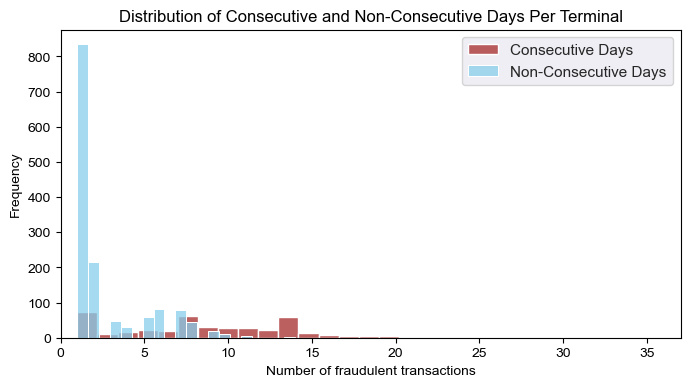

In [9]:
_, ax = plt.subplots(1, 1, figsize=(8,4))

consecutive_counts = diffs[diffs["DAY_DIFF"] == 1]["TERMINAL_ID"].value_counts()
non_consecutive_counts = diffs[diffs["DAY_DIFF"] > 1]["TERMINAL_ID"].value_counts()

sns.set_theme(style="darkgrid")
sns.histplot(x=consecutive_counts, bins=30, kde=False, ax=ax, color="brown")
sns.histplot(x=non_consecutive_counts, bins=20, kde=False, ax=ax, color='skyblue')
ax.set_xlim([0, max(consecutive_counts.max(), non_consecutive_counts.max())])
ax.set(xlabel = "Number of fraudulent transactions", ylabel="Frequency",
       title="Distribution of Consecutive and Non-Consecutive Days Per Terminal")
ax.legend(["Consecutive Days", "Non-Consecutive Days"]);

To address this, we had to implement a way in our classification approach that acknowledges that past fraudulent activity at a terminal is a strong factor, but not all future transactions at that terminal should be flagged as fraud.

Our exploration analysis showed many key significant insights into fraud detection, which include class imbalance, transaction amount and terminal level indicators. Those findings gave us information that was necessary to implement our feature engineering and modeling approach to account for the customer and terminal behavior patterns and minimize our bias in our model.

# Feature Engineering

To create a robust fraud detection, we engineered features that capture both population fraud trends and individual customer-based spending behaviors. This creates a model that can detect a wide range of fraud tactics while also identifying personalized anomalies that could indicate fraudulent activity at a customer level.

Transaction amount serves as a critical indication in fraudulent activity. We applied a Z-score normalization to standardize transactions relative to the dataset mean, which ensures that large transaction values were flagged as unusual. However, some of the fraudulent activities attempted to fall within the customer expected ranges but still would appear abnormal compared to overall transaction patterns. Since specific terminals were exploited, we implemented rolling seven-and twenty-eight day rolling fraud rates. Acknowledging that a terminal who has had fraudulent activity doesn’t mean they will always be fraudulent we implemented an exponential decay factor to ensure old occurrences of fraud had a diminishing influence in our model and attempting to prevent model but still capturing consistent fraud risk. To further improve our population fraud trend, we implemented a Local Outlier Factor (LOF), and an unsupervised anomaly detection method that assigned a likelihood of fraud score based on its behavior. This method creates context-based detecting and maintains to not solely rely on extreme transaction values. During the feature engineering process we considered using an Isolation Forest for our unsupervised choice, but the anomaly score made our model rely on the Isolation Forest prediction, which reduced its ability to learn other fraudulent trends.

Listed below shows all population-based features that were created.

\begin{table}[h]
    \centering
    \begin{tabular}{| l | p{10cm} |}
        \hline
        \textbf{Feature} & \textbf{Purpose} \\
        \hline
        TX\_AMOUNT\_Z\_Score & Check for extreme transaction amounts compared to data set's mean \\
        \hline
        TX\_AMOUNT\_Percentile & Check transaction amounts relative to all others \\
        \hline
        TERMINAL\_FRAUD\_RATIO & Terminal-level fraud check that decays over time \\
        \hline
        ANOMALY\_SCORE (LOF) & Unsupervised learning to apply a score beyond deviation of previous features \\
        \hline
    \end{tabular}
    \caption{Feature Description and Purpose}
    \label{tab:feature_purpose}
\end{table}

The population-based trend provides a big picture view of our sample, but fraudulent transactions often are different from customer behavior rather than population norm. To recognize this, we engineered features that will adapt to each customer's unique spending habits instead of over relying on dataset wide fraud indicators. The key feature of detecting fraud at a customer level is track spending behavior over time. We computed a 14-day rolling window that tracks whether a customer suddenly makes a significant change in their spending habits. This can help with identifying fraud scenarios where fraudsters make large transactions over a short period, deviation from previous spending habits. We normalized the transaction amount based on each customer's historical data instead of the entire data set. This implementation prevents the model from flagging frequently high spending larger transactions, while still detecting unexpected large purchases from lower spending customers.

The table below shows all customer-based features that were created.

\begin{table}[h]
    \centering
    \begin{tabular}{| l | p{10cm} |}
        \hline
        \textbf{Customer-Based Features} & \textbf{Purpose} \\
        \hline
        SPENDING\_RATIO\_CHANGE & Checks for sudden shifts in customer spending behavior \\
        \hline
        SPENDING\_Z\_SCORE\_28D & Identifies how unusual a transaction is for a specific customer based on their historical spending patterns \\
        \hline
    \end{tabular}
    \caption{Customer-Based Features and Their Purpose}
    \label{tab:customer_features}
\end{table}

By looking at both the population and customer-based fraud detection the purpose is to create a model that can identify fraud trends that are occurring at large scale but also adapting to customer level behavior. This combination with dynamic adjusting and personalized profiles attempts to create a fraud detection model that is both effective and adaptable at identifying ever changing fraud tactics.
With the creation of these engineered features, we now will focus on model selection and evaluating different approaches at models to classify fraudulent activity effectively

In [10]:
# Feature Engineering Rolling Windows with decay
scaler = StandardScaler()
train_df['TX_AMOUNT_Z_SCORE'] = scaler.fit_transform(train_df[['TX_AMOUNT']])
test_df['TX_AMOUNT_Z_SCORE'] = scaler.transform(test_df[['TX_AMOUNT']])

train_df['TX_AMOUNT_PERCENTILE'] = train_df['TX_AMOUNT'].rank(pct=True)
test_df['TX_AMOUNT_PERCENTILE'] = test_df['TX_AMOUNT'].rank(pct=True)

# Optimize Decay Factor 
decay_values = np.linspace(0.8, 0.99, 20)  
best_decay, best_corr = 0.95, float('-inf')  

for decay in decay_values:
    temp_df = train_df.copy()
    temp_df['TERMINAL_FRAUD_RATIO_28D'] = (
        temp_df.groupby('TERMINAL_ID')['TX_FRAUD']
        .shift(1)
        .ewm(alpha=1-decay)
        .mean()
    )
    correlation = temp_df['TERMINAL_FRAUD_RATIO_28D'].corr(temp_df['TX_FRAUD'])
    
    if correlation > best_corr:
        best_corr = correlation
        best_decay = decay

optimal_decay = best_decay  # Best decay factor based on correlation

# Apply the optimized decay factor
train_df['TERMINAL_FRAUD_RATIO_28D'] = (
    train_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .ewm(alpha=1-optimal_decay)
    .mean()
)
test_df['TERMINAL_FRAUD_RATIO_28D'] = (
    test_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .ewm(alpha=1-optimal_decay)
    .mean()
)

# Terminal Fraud Ratios
train_df['TERMINAL_FRAUD_RATIO_7D'] = (
    train_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .rolling(7, min_periods=1)
    .mean()
)
test_df['TERMINAL_FRAUD_RATIO_7D'] = (
    test_df.groupby('TERMINAL_ID')['TX_FRAUD']
    .shift(1)
    .rolling(7, min_periods=1)
    .mean()
)

# Customer Spending Trends
train_df['SPENDING_RATIO_CHANGE'] = (
    train_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: x.pct_change().rolling(14, min_periods=1).mean())
)
test_df['SPENDING_RATIO_CHANGE'] = (
    test_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: x.pct_change().rolling(14, min_periods=1).mean())
)

train_df['SPENDING_Z_SCORE_28D'] = (
    train_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: (x - x.mean()) / (x.std() + 1))
)
test_df['SPENDING_Z_SCORE_28D'] = (
    test_df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .transform(lambda x: (x - x.mean()) / (x.std() + 1))
)


# Anomaly Detection (Local Outlier Factor)
features_for_lof = ['TX_AMOUNT_Z_SCORE', 'SPENDING_RATIO_CHANGE', 'TERMINAL_FRAUD_RATIO_28D']
train_df[features_for_lof] = train_df[features_for_lof].fillna(train_df[features_for_lof].median())
test_df[features_for_lof] = test_df[features_for_lof].fillna(test_df[features_for_lof].median())

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005, novelty=True)
lof.fit(train_df[features_for_lof].values)

train_df['ANOMALY_SCORE'] = lof.decision_function(train_df[features_for_lof].values)
test_df['ANOMALY_SCORE'] = lof.decision_function(test_df[features_for_lof].values)

# Normalize Anomaly Scores
scaler = MinMaxScaler()
train_df['ANOMALY_SCORE'] = scaler.fit_transform(train_df[['ANOMALY_SCORE']])
test_df['ANOMALY_SCORE'] = scaler.transform(test_df[['ANOMALY_SCORE']])

In [11]:
engineered_features = ['TX_AMOUNT_Z_SCORE',
                       'TX_AMOUNT_PERCENTILE',
                       'TERMINAL_FRAUD_RATIO_7D',
                       'TERMINAL_FRAUD_RATIO_28D',
                       'SPENDING_RATIO_CHANGE',
                       'SPENDING_Z_SCORE_28D',
                       'ANOMALY_SCORE']

for feature in engineered_features:
    median_value = train_df[feature].median()
    train_df[feature] = train_df[feature].fillna(median_value)
    test_df[feature] = test_df[feature].fillna(median_value)

# Model Selection

*Isolation Forest, Balanced Random Forest, etc*

# Model Training and Evaluation

Let's talk a little bit about how we're going to be scoring our models. We'll be using 4 scores to determine how well our models perform: Precision, Recall, F1, and a PR-AUC score.

- Precision: Correctly identified fraudulent cases across all *classified* fraudulent cases
- Recall: Correctly identified fraudulent cases across all *truly* fraudulent cases
- F1: A metric providing a balanced measure of the harmonic mean of precision and recall
- PR-AUC: The model's ability to distinguish between classes

We won't be working with accuracy scores as with imbalanced data, accuracy scores tend to mislead people into believing the model fits the data well by reporting high numbers, when in reality it's only that high because it can accurately predict the *majority* class while being horrible at accurately predicting the *minority* class.

In [12]:
def model_run(model: XGBClassifier | StackingClassifier):
    # Train the model
    model.fit(train_df[engineered_features], train_df['TX_FRAUD'])
    
    # Predictions
    y_pred = model.predict(test_df[engineered_features])
    y_scores = model.predict_proba(test_df[engineered_features])[:,1]

    precision = precision_score(test_df['TX_FRAUD'], y_pred)
    recall = recall_score(test_df['TX_FRAUD'], y_pred)
    f1 = f1_score(test_df['TX_FRAUD'], y_pred)
    pr_auc = average_precision_score(test_df['TX_FRAUD'], y_scores)

    print("Classification Report:\n", classification_report(test_df['TX_FRAUD'], y_pred))
    print(f"PR-AUC: {pr_auc:.4f}")

## Balanced Random Forest (BRF)

### Base Dataset

Considering that we decided to feature-engineer the dataset to the point where none of the original features were left being used by our models, how well does the original dataset perform with one of our models? Was the feature engineering all for naught?

In [13]:
split_point = df['TX_TIME_DAYS'].quantile(0.8)
base_train_df = df[df['TX_TIME_DAYS'] < split_point].copy()
base_test_df = df[df['TX_TIME_DAYS'] >= split_point].copy()

# Extract features and target variable
base_features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_HOUR', 'TX_DAYOFWEEK']
target = 'TX_FRAUD'

X_train, y_train = base_train_df[base_features], base_train_df[target]
X_test, y_test = base_test_df[base_features], base_test_df[target]

# Initialize Balanced Random Forest
base_brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
base_brf_model.fit(X_train, y_train)

# Predictions
y_pred = base_brf_model.predict(X_test)
y_proba = base_brf_model.predict_proba(X_test)[:, 1]  # Get probability scores for ROC-AUC

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("PR-AUC:", average_precision_score(y_test, y_proba).round(4))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90    351466
           1       0.02      0.43      0.04      3177

    accuracy                           0.82    354643
   macro avg       0.51      0.63      0.47    354643
weighted avg       0.99      0.82      0.89    354643

PR-AUC: 0.2375


With a precision rate of 0.02, recall rate of 0.43, and F1 score of 0.04, no, the feature engineering is very much necessary.

### Feature-Engineered Dataset

In [14]:
brf_model = BalancedRandomForestClassifier(n_estimators=500, max_depth=15, random_state=42, class_weight='balanced_subsample')

model_run(brf_model)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    351466
           1       0.31      0.89      0.46      3177

    accuracy                           0.98    354643
   macro avg       0.65      0.94      0.72    354643
weighted avg       0.99      0.98      0.99    354643

PR-AUC: 0.6857


## XGBoost

In [15]:
# Make weights
neg_count = train_df['TX_FRAUD'].value_counts()[0]
pos_count = train_df['TX_FRAUD'].value_counts()[1]
scale_pos_weight = neg_count / pos_count

# Run XGBoost
xgb_model: XGBClassifier = XGBClassifier()
xgb_model.objective = 'binary:logistic'
xgb_model.scale_pos_weight = scale_pos_weight

model_run(xgb_model)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    351466
           1       0.36      0.86      0.50      3177

    accuracy                           0.98    354643
   macro avg       0.68      0.92      0.75    354643
weighted avg       0.99      0.98      0.99    354643

PR-AUC: 0.5868


In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# grid_search = GridSearchCV(xgb_model, param_grid, scoring='average_precision', cv=3, n_jobs=3)
# grid_search.fit(train_df[features], train_df['TX_FRAUD'])

# best_xgb = grid_search.best_estimator_

# model_run(best_xgb)

## Stacking BRF and XGBoost

In [ ]:
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[
        ('brf', brf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_model,
    passthrough=True
)

model_run(stacking_model)

# Model Interpretation and Explainability

- Talk about the Scenarios here
    - Which scenarios did each model miss 
- Pull feature importance
- What scenarios did the model miss  
- Talk about each model's performance 
- All Together
    - Are there similarities in feature use 
    - Does our feature engineering align with fraud indicators 
- Talk about Interpretability vs Accuracy Debate once again

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(12, 12))

brf_importances = pd.DataFrame({'Features': engineered_features, 'BRF': brf_model.feature_importances_})
xgb_importances = pd.DataFrame({'Features': engineered_features, 'XGB': xgb_model.feature_importances_})

sns.barplot(y="Features", x="BRF", ax=ax[0], data=brf_importances.sort_values(by="BRF", ascending=False))
ax[0].set(xlabel = "Feature Importance Score (BRF)", ylabel="Features")
sns.barplot(y="Features", x="XGB", ax=ax[1], data=xgb_importances.sort_values(by="XGB", ascending=False))
ax[1].set(xlabel = "Feature Importance Score (XGB)", ylabel="Features");

In [ ]:
df2 = pd.concat([train_df, test_df], axis=0)

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(8, 8))
_.tight_layout(h_pad=4)
sns.set_theme(style="darkgrid")

sns.histplot(data=df2[df2['TX_FRAUD'] == 0], x='SPENDING_Z_SCORE_28D', ax=ax[0], color='cornflowerblue')
ax[0].set(xlabel = "Customer Spending Z-Scores", ylabel="Count",
          title="Distribution of Customer Spending Z-Scores within a 28-Day Rolling Window for Non-Fraudulent Transactions");
sns.histplot(data=df2[df2['TX_FRAUD'] == 1], x='SPENDING_Z_SCORE_28D', ax=ax[1], color='tomato')
ax[1].set(xlabel = "Customer Spending Z-Scores", ylabel="Count",
          title="Distribution of Customer Spending Z-Scores within a 28-Day Rolling Window for Fraudulent Transactions");

# Conclusion

- What could we change and improve upon 
    - Strengths 
    - Key Takeaways 
    - Additional real time features?
- Talk about the challenges we faced 
    - Did Certain fraud patterns remain undetected 
- Talk about if we choose to implement this into real world
    - How can it be used 
    - Impact on customers 
    - Could this be deployed 
    - How much human interaction would be necessary due to this implementation  

# References

TODO: Figure out how to wrap text

- https://www.security.org/digital-safety/credit-card-fraud-report/
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html
- https://www.aporia.com/learn/ultimate-guide-to-precision-recall-auc-understanding-calculating-using-pr-auc-in-ml/